In [5]:
import pandas as pd
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle,class_weight
#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
# Audio
import librosa
import librosa.display

# Plot
import matplotlib.pyplot as plt

# Utility
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools

In [7]:
dataset = []
for folder in ["D:\\machine\\projects\\New folder (2)\\heartbeat-sounds\\dataset\\set_a\\**","D:\\machine\\projects\\New folder (2)\\heartbeat-sounds\\dataset\\set_b\\**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            # skip audio smaller than 4 secs
            if librosa.get_duration(filename=filename)>=4:
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    dataset.append({
                        "filename": filename,
                        "label": label
                    })
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)

In [8]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 70 to 102
Data columns (total 2 columns):
filename    404 non-null object
label       404 non-null object
dtypes: object(2)
memory usage: 9.5+ KB


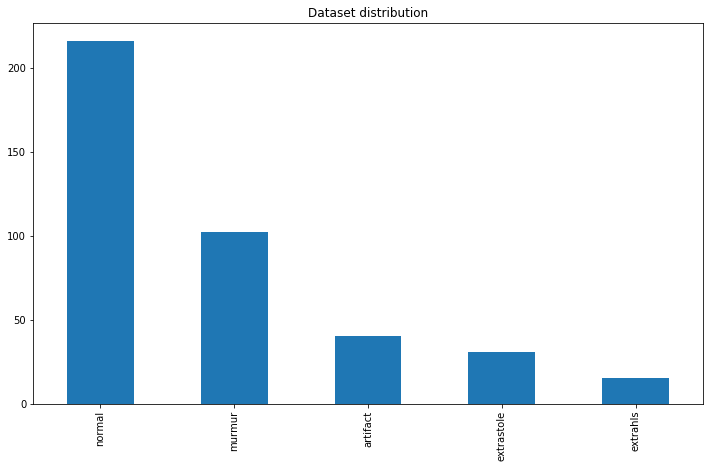

In [11]:
plt.figure(figsize=(12,7))
dataset.label.value_counts().plot(kind='bar',title='Dataset distribution')
plt.show()

In [13]:
train,test=train_test_split(dataset,test_size=0.2,random_state=42)
print("train %i"% len(train))
print("test %i "% len(test))

train 323
test 81 


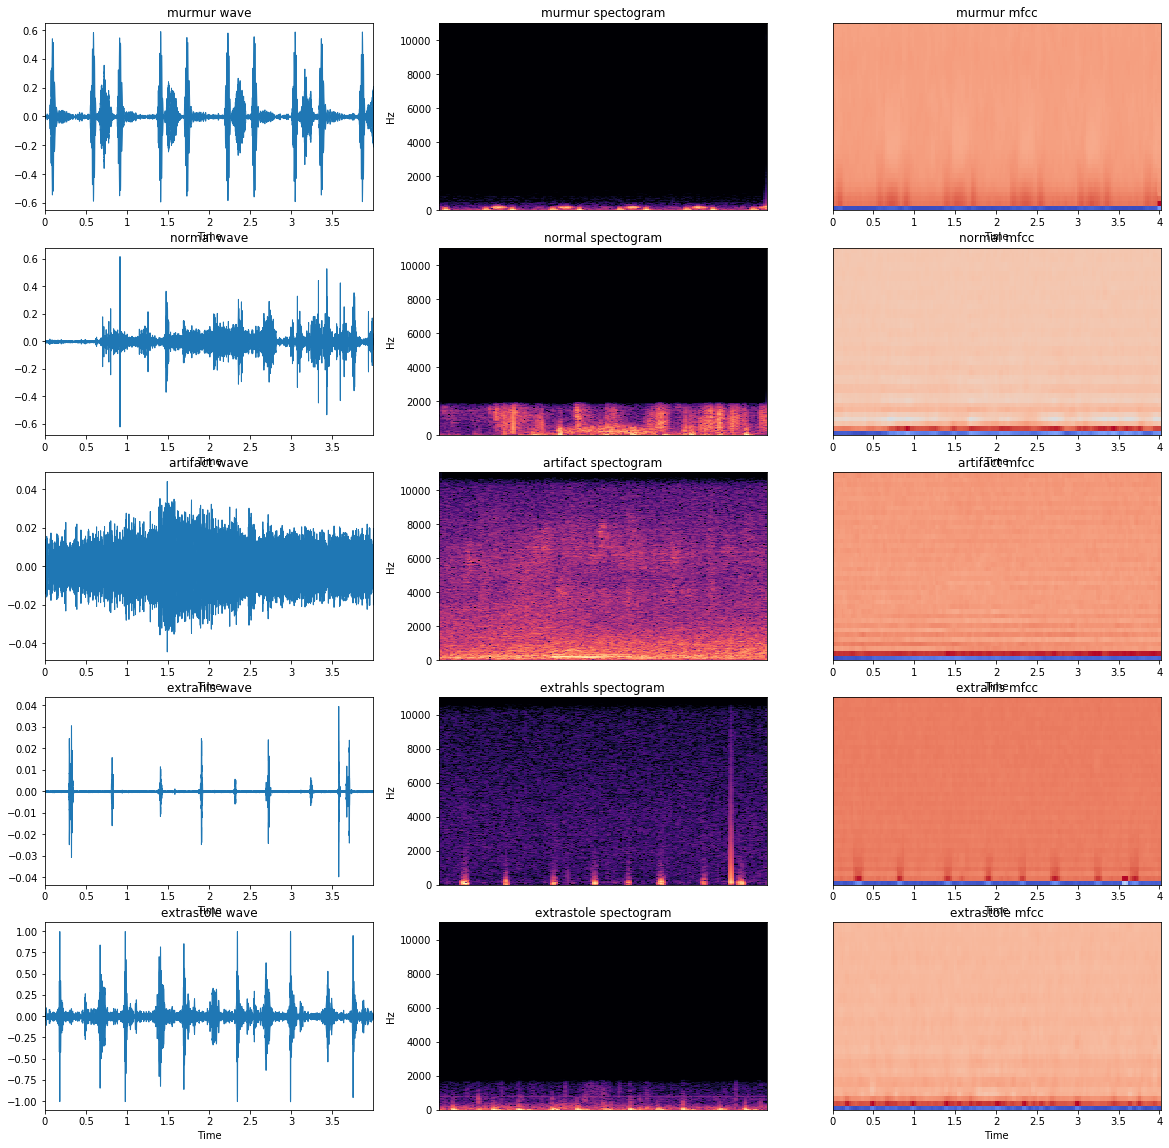

In [14]:
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[0], duration=4)
    #plot_wave
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title("%s wave" % label)
    librosa.display.waveplot(y, sr=sr)
    #plot_spectogram
    idx+=1
    plt.subplot(5, 3, idx)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.title("%s spectogram" % label)
    #plot_mfcc
    idx+=1
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc" % label)
plt.show()

In [15]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [18]:
%%time
x_train, x_test = [], []
print("Extract features from TRAIN  and TEST dataset")
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

Extract features from TRAIN  and TEST dataset


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:13<00:00,  5.60it/s]


X train: (323, 40, 173)
X test: (81, 40, 173)
Wall time: 1min 5s


In [22]:
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)


In [23]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [24]:
class_weights

array([2.08387097, 5.87272727, 2.584     , 0.82820513, 0.36292135])

In [25]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print()
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (323, 40, 173, 1)
Y train: (323, 5)

X test: (81, 40, 173, 1)
Y test: (81, 5)


In [26]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 42, 32)         0         
______________________

In [28]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [29]:
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              class_weight=class_weights,
              shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 323 samples, validate on 81 samples
Epoch 1/300
323/323 [==============================] - ETA: 3s - loss: 8.0535 - acc: 0.210 - ETA: 0s - loss: 6.9764 - acc: 0.394 - 4s 11ms/step - loss: 7.1249 - acc: 0.4025 - val_loss: 4.9511 - val_acc: 0.4691
Epoch 2/300
323/323 [==============================] - ETA: 1s - loss: 5.6740 - acc: 0.460 - ETA: 0s - loss: 5.7814 - acc: 0.453 - 2s 5ms/step - loss: 5.5899 - acc: 0.4706 - val_loss: 4.3371 - val_acc: 0.4691
Epoch 3/300
323/323 [==============================] - ETA: 0s - loss: 4.7955 - acc: 0.437 - ETA: 0s - loss: 5.2874 - acc: 0.453 - 2s 5ms/step - loss: 5.1237 - acc: 0.4737 - val_loss: 5.3479 - val_acc: 0.4691
Epoch 4/300
323/323 [==============================] - ETA: 0s - loss: 4.9694 - acc: 0.539 - ETA: 0s - loss: 5.3299 - acc: 0.500 - 2s 5ms/step - loss: 5.2498 - acc: 0.4892 - val_loss: 4.2564 - val_acc: 0.5309
Epoch 5/300
323/323 [===

Text(0.5, 1.0, 'Accuracy Curves')

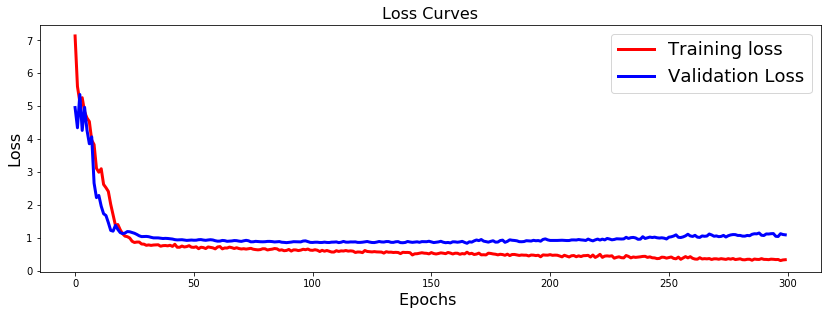

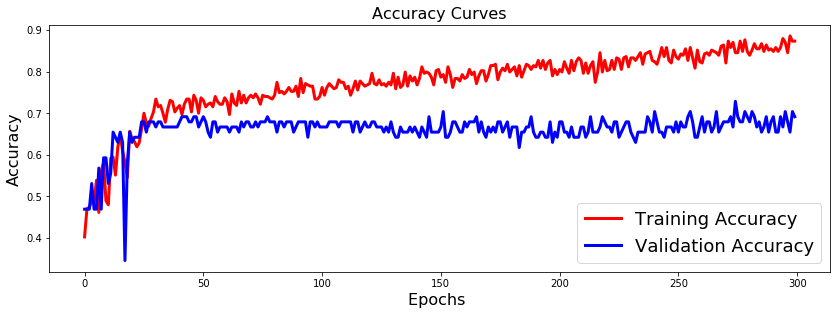

In [30]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [33]:
model_name = "D:\\machine\\projects\\New folder (2)\\heartbeat-sounds\\heartbeat_disease.h5"
model.save(model_name)